THE FIREFIGTER PROBLEM


In [1]:
def clp(G, B, gasilci, cas):
    # vhodni podatki:
    #     G           izbran graf
    #     B           vozlišča, ki na začetku zgorijo
    #     gasilci     število gasilcev, ki v vsakem koraku gasijo požar
    #     cas         maksimaleno število časovnih enot
    # izhodni podatki:
    #     seznam oblike [število časovnih enot, pogorela/burnt vozlišča po časih, zaščitena/defended vozlišča po časih]
 
    casi = range(1, cas+1) # uprabljamo pri zankah
    
    # CLP:
    p = MixedIntegerLinearProgram(maximization=False) # CLP
    d = p.new_variable(binary=True) # spremenljivka, defended
    b = p.new_variable(binary=True) # spremenljivka, burnt

    p.set_objective(sum(b[i, cas] for i in G)) # minimiziramo število pogorelih vozlišč na koncu 

    for t in casi:
        for i in G:
            for j in G[i]: # j je številka v seznamu vozlišča i, sosed od i
                p.add_constraint(b[i,t] + d[i,t] - b[j,t-1] >= 0)
            p.add_constraint(b[i,t] + d[i,t] <= 1)
            p.add_constraint(b[i,t] - b[i,t-1] >= 0)
            p.add_constraint(d[i,t] - d[i,t-1] >= 0)
        p.add_constraint(sum((d[i,t] - d[i,t-1]) for i in G) <= gasilci)

    for i in G:
        p.add_constraint(b[i,0] == (1 if i in B else 0))
        p.add_constraint(d[i,0] == 0)
        
    return [p.solve(), p.get_values(b), p.get_values(d)]


def skrcitev(dic, t):
    # pomožna funkcija skrcitev vrne seznam, ki vsebuje vozlišča, ki jih je potrebno pobarvati (imajo vrednost ključa 1) v določenem času

    new = []
    for key in dic:
        if key[1] == t and dic[key] == 1:
            new.append(key[0])
    return new


def ali_je_problem_koncan(G, B, gasilci, cas, t):
    # funkcija nam pove ali je problem v času t zaključen/končen
    
    b = skrcitev(clp(G, B, gasilci, cas)[1], t) # burnt vozlišča v t
    d = skrcitev(clp(G, B, gasilci, cas)[2], t) # defended vozlišča v t
    skupaj = b + d

    # sosedi od pogorelih vozlišč so lahko pogoreli ali zaščiteni. Ne smejo biti prazna vozlišča
    for pogorelo_vozlisce in b:
        for sosed_od_pogorelo_vozlisce in G[pogorelo_vozlisce]:
            if sosed_od_pogorelo_vozlisce not in skupaj:
                return False
    return True

   
def cas_potreben(G, B, gasilci, cas):
    # iz p.solve() pridobi čas po katerem se nič več ne spremeni -> dobimo potreben čas
    
    burnt = clp(G, B, gasilci, cas)[1]
    defended = clp(G,B,gasilci,cas)[2]

    urej_burnt = sorted(burnt.items(), key=lambda tup: tup[0][1]) #uredi glede na čas po vozliščih naraščajoče
    urej_defended = sorted(defended.items(), key=lambda tup: tup[0][1]) 

    vredn_burnt= []
    for i, v in urej_burnt:
        vredn_burnt.append(v)
    #pridobim ven vrednosti spremnljivk b v časih in vozliščih naraščajoče

    vredn_defended= []
    for i, v in urej_defended:
        vredn_defended.append(v)
    #pridobim ven vrednosti spremnljivk d v časih in vozliščih naraščajoče

    #from itertools import islice
    from itertools import accumulate
    dolzina = [len(G)] * (cas +1) # Vrednosti zgrupiram v paketke, v vsakem je toliko vrednosti, kolikor je vozlišč
    seznami_vrednosti_po_casih_burnt = [vredn_burnt[x - y: x] for x, y in zip(
                        accumulate(dolzina), dolzina)]

    seznami_vrednosti_po_casih_defended = [vredn_defended[x - y: x] for x, y in zip(
                        accumulate(dolzina), dolzina)]

    i = 0
    while seznami_vrednosti_po_casih_burnt[i] != seznami_vrednosti_po_casih_burnt[i+1]:
        i = i+1
    i    

    j = 0
    while seznami_vrednosti_po_casih_defended[j] != seznami_vrednosti_po_casih_defended[j+1]:
        j = j+1
    j 

    return max(i, j) #večji od časev ko se neha spreminjati



def barvanje_v_casu_t(G, B, gasilci, cas, t):
    # pomožna funkcija barvanje_v_casu_t izriše graf in pobarva vozlišča v določenem času (t). Začetna vozlišča oz. izvor pošara pobarva v zeleno, 
    #     pogorela v  rdečo, zaščitena pa v modro. 

    b = skrcitev(clp(G, B, gasilci, cas)[1], t) # burnt vozlišča v času t BREZ ZAČETNIH VOZLIŠČ B
    for el in B:
        b.remove(el)
    d = skrcitev(clp(G, B, gasilci, cas)[2], t) # defended vozlišča v času t
    
    return G.show(partition = [b, B, d])


def barvanje_po_korakih(G, B, gasilci, cas, t):
    # funkcija, ki za vsako časovno enoto nariše situacijo na grafu
    #     barve:
    #         - zelena: oglišča kjer se požar začne (B)
    #         - rdeča: pogorela
    #         - modra: zaščitena
    
    if ali_je_problem_koncan(G, B, gasilci, cas, t) == False:
        return 'V izbranem času problem še ni zaključen.'
    
    else:    
        time = cas_potreben(G, B, gasilci, cas)
        print("Število potrebnih časovnih korakov: " + str(time))
        for t in range(0, time + 1):
            print("Situacija v času " + str(t) + ":")
            barvanje_v_casu_t(G, B, gasilci, cas, t)


In [2]:
# PRIMER 1:
G1 = graphs.Grid2dGraph(3, 4)
B1 = [(1, 1), (2, 2)]
gasilci1 = 2
cas1 = 10
cas_potreben(G1,B1,gasilci1,cas1)
#barvanje_po_korakih(G1, B1, gasilci1, cas1, 3)
#ali_je_problem_koncan(G1, B1, gasilci1, cas1, 2)
#ali_je_problem_koncan(G1,B1,gasilci1,1,1) #lahko preverjamo, če je cas1 uredu, recimo tukaj cas1 = 1 ni uredu, ker na koncu (t=1) še problem ni končan

3

In [4]:
# PRIMER 2:
G2 = graphs.PetersenGraph()
B2 = [1,5]
gasilci2 = 3
cas2 = 10
#barvanje_po_korakih(G2, B2, gasilci2, cas2, 2)
#ali_je_problem_koncan(G2, B2, gasilci2, cas2, 2)

In [5]:
# PRIMER 3:
G3 = graphs.PappusGraph()
B3 = [0,1,2,3]
gasilci3 = 3
cas3 = 2
#barvanje_po_korakih(G3, B3, gasilci3, cas3, 3)
#ali_je_problem_koncan(G3, B3, gasilci3, cas3, 4)

In [11]:
# različni grafi (poimenovano GG*) glede na število vozlišč:
# 5: 
GG1 = graphs.BullGraph()
GG2 = graphs.ButterflyGraph()
GG3 = graphs.GemGraph()
GG4 = graphs.HouseXGraph()

# 12:
GG5 = graphs.HeawoodGraph() # ta mi je všeč

# 13:
c = graphs.CycleGraph(5)
p = graphs.PathGraph(3)
GG6 = p.cartesian_product(c)

# 16:
GG7 = graphs.PappusGraph()

# na izbranem številu vozlišč:
GG8 = graphs.CircularLadderGraph(3) # namesto 3 se lahko da katerokoli številko npr. n in bo imel 2*n vozlišč
GG9 = graphs.Grid2dGraph(3,5) # matrika 3 x 5

# PREBERI NASLEDNJE: 
# 
# grafi na izbranem številu vozlišč se mi zdi, da so še najbolš, ker lahko narediva zanko, ki nam jih bo vračala kar sama. Bova pa seveda
#     vključile tudi ostale grafe. Poglej še ti, če najdeš kakšne, kjer se da število vozlišč notr in primerni.
#
# za vsak graf bi morali sami določiti B in število gasilcev. Predlagam, da število gasilcev res sami določiva za vse grafe 
#     kar enako število (npr. 2 ali 3, da jih ne bo preveč, lahko tudi ločiva primere). 
#     Za množico B pa se mi zdi, da bi bilo najboljše, če bi pythonu rekle, da kar sam izbere 2 poljubni vozlišči, ker itak običajno ne vemo 
#     kje požar izbruhne in še manj dela bi imele. In lahko isti graf (z n vozlišči) kar dvakrat ali večkrat uporabimo, ker itak se bo B spreminjal. 
#
# Prav tako pa se mi zdi, da ČE BOVA DELALI .csv DATOTEKO MORAVA NAREDITI ŠE LOČENO .py DATOTEKO, KER PREKO TEGA PROGRAMA VERJETN NE BO ŠLO



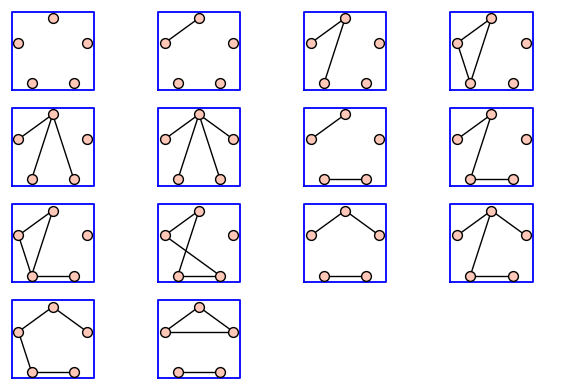

In [7]:
# Generate all graphs with 5 vertices and up to 4 edges. #edges je število povezav
L = list(graphs(5, lambda G: G.size() <= 4))
len(L)
graphs_list.show_graphs(L) # long time

# Lahko uporabiva ta generate za grafe, samo pri večjem številu vozlišč bo delalo zelo dolgo časa. -> Lahko potem za tisto testiranje ali_je_problem_koncan ??

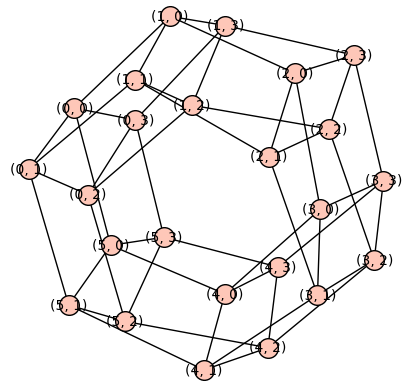

In [15]:
K = graphs.CycleGraph(6).cartesian_product(graphs.CycleGraph(4)) #ta je 3D, mogoče bi bilo super tudi take
K.plot()

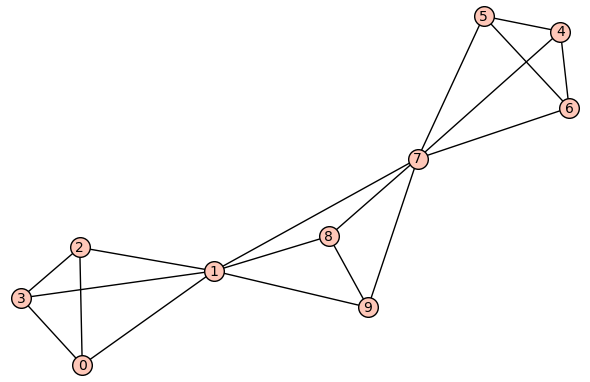

In [19]:
R = graphs.RandomBlockGraph(3, 4) 
R.plot()